# All-Zone Analysis of UCB-Based Policy Selection

1. Compare the number of evaluations vs Spearman Rank Correlation to validation data
2. UCB evaluates each policy for 1-day and takes aggregate energy consumption as reward
3. Tested on the 15-zone test building

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm.notebook import tqdm
import os

%matplotlib widget

## Valdiation Data

In [2]:
eval_data_loc = "../data/eval_data/evaluation_report_20220820.csv"
invalid_policies_loc = "../data/invalid_policy_list.json"

eval_df = pd.read_csv(eval_data_loc, header=None, names=["datetime", "policy", "zone", "energy"])
# with open(invalid_policies_loc) as f:
#     invalid_policies = json.load(f)["invalid_policies"]
invalid_policies = []

## UCB Zone Data

In [3]:
all_zones = list(eval_df["zone"].unique())

# ucb_df = pd.read_csv("../data/group_ucb_log_data/8/ucb_log_data.csv")  # Dummy testcase
ucb_df = pd.read_csv("../data/group_ucb_log_data/18/ucb_log_data.csv")

In [4]:
ucb_eval_cols = ucb_df.columns
arm_names = [col[:-6] for col in ucb_eval_cols if "score" in col]
num_policies = len(arm_names)

## UCB Q-Value Plot

In [5]:
q_vals_df = pd.DataFrame()
q_vals_df["timestep"] = ucb_df[len(arm_names):].index
q_vals_df["total_energy"] = ucb_df["total_energy"] / 4000000

for arm in arm_names:
    score_col_name = f"{arm}_score"
    count_col_name = f"{arm}_count"
    all_columns = list(ucb_df.columns)
    q_vals_df[f"{arm}_value"] = ucb_df.iloc[len(arm_names):, all_columns.index(score_col_name)].values
    q_vals_df[f"{arm}_count"] = ucb_df.iloc[len(arm_names):, all_columns.index(count_col_name)].values
    q_vals_df = q_vals_df.copy()

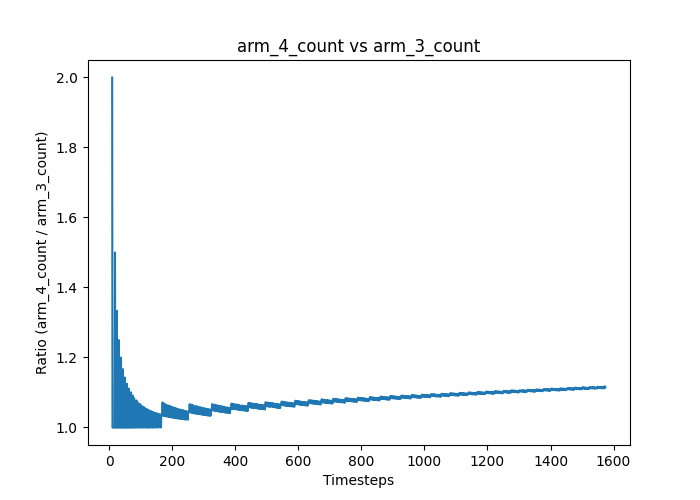

In [31]:
start = len(arm_names)
arm_a = 4
arm_b = 3
plt.figure(figsize=(7, 5))
plt.title(f"arm_{arm_a}_count vs arm_{arm_b}_count")
plt.xlabel("Timesteps")
plt.ylabel(f"Ratio (arm_{arm_a}_count / arm_{arm_b}_count)")
ratios = q_vals_df[f"arm_{arm_a}_count"] / q_vals_df[f"arm_{arm_b}_count"]
plt.plot(q_vals_df["timestep"], ratios)

0it [00:00, ?it/s]

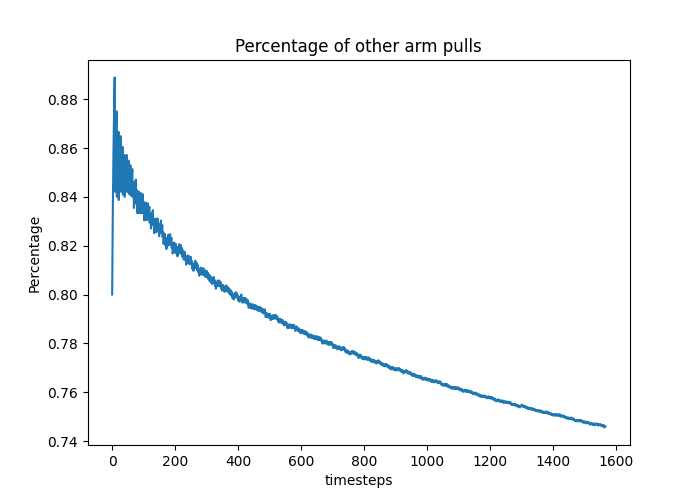

In [57]:
main_arm = 4
x = []
y = []
for i, row in tqdm(q_vals_df.iterrows()):
    main_arm_name = f"arm_{main_arm}"
    other_arms = list(set(arm_names) - set([main_arm_name]))
    other_arm_count_col_names = [name+"_count" for name in other_arms]
    all_arm_count_col_names = [name+"_count" for name in arm_names]
    total_other_arm_count = row[other_arm_count_col_names].values.sum()
    total_all_arm_count = row[all_arm_count_col_names].values.sum()
    other_arm_frac = total_other_arm_count / total_all_arm_count
    
    x.append(i)
    y.append(other_arm_frac)

plt.figure(figsize=(7, 5))
plt.title("Percentage of other arm pulls")
plt.ylabel("Percentage")
plt.xlabel("timesteps")
plt.plot(x, y)


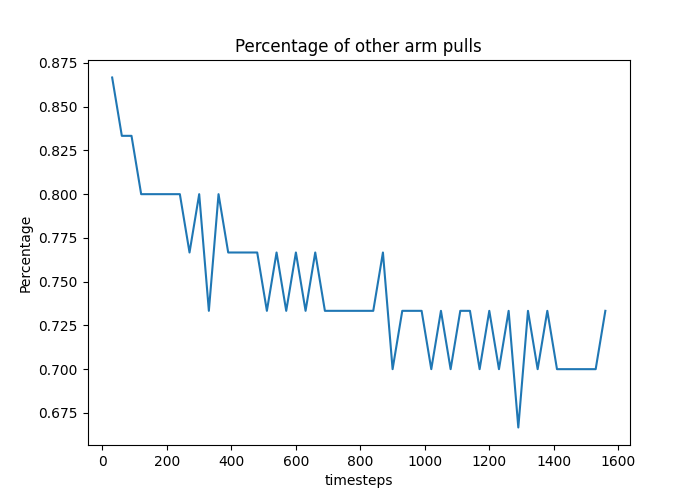

In [67]:
main_arm = 4
interval_size = 30
x = []
y = []
for i in range(interval_size, len(q_vals_df), interval_size):
    main_arm_name = f"arm_{main_arm}"
    other_arms = list(set(arm_names) - set([main_arm_name]))
    other_arm_count_col_names = [name+"_count" for name in other_arms]
    all_arm_count_col_names = [name+"_count" for name in arm_names]
    other_arm_counts = q_vals_df.loc[i, other_arm_count_col_names].values
    other_arm_count_tm1 = q_vals_df.loc[i-interval_size, other_arm_count_col_names].values
    other_arm_diff = (other_arm_counts - other_arm_count_tm1).sum()
    
    other_arm_frac = other_arm_diff / interval_size
    
    x.append(i)
    y.append(other_arm_frac)

plt.figure(figsize=(7, 5))
plt.title("Percentage of other arm pulls")
plt.ylabel("Percentage")
plt.xlabel("timesteps")
plt.plot(x, y)


In [65]:
len(q_vals_df)

1566

In [48]:
other_arms

['arm_3', 'arm_5', 'arm_7', 'arm_1', 'arm_8', 'arm_2', 'arm_6', 'arm_0']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


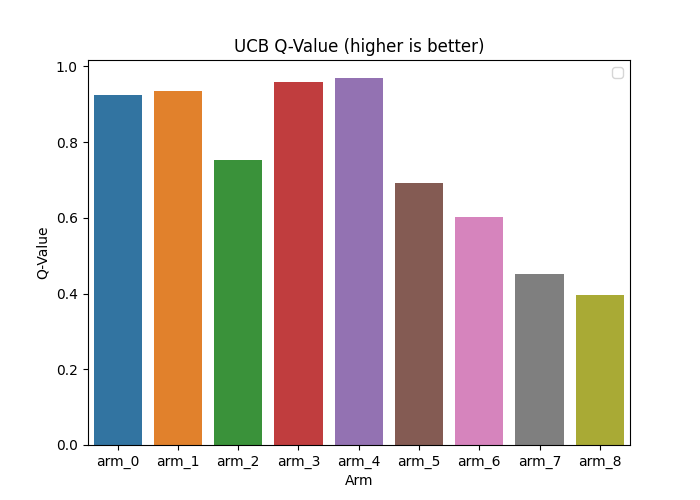

In [6]:
q_bar_plot_df = {"arm": [],
                 "score": []}
for arm in arm_names:
    q_bar_plot_df["arm"].append(arm)
    q_bar_plot_df["score"].append(1+q_vals_df[f"{arm}_value"].values[-1])

plt.figure(figsize=(7, 5))
plt.title("UCB Q-Value (higher is better)")
# for i, arm in enumerate(arm_names):
#     # sns.lineplot(x="timestep", y=f"{arm}_value", data=q_vals_df)
#     if i == 6:
#         alpha = 1
#     else:
#         alpha = 0.1
sns.barplot(x="arm", y="score", data=q_bar_plot_df)
plt.ylabel("Q-Value")
plt.xlabel("Arm")
plt.legend()

Text(0.5, 0, 'Arm')

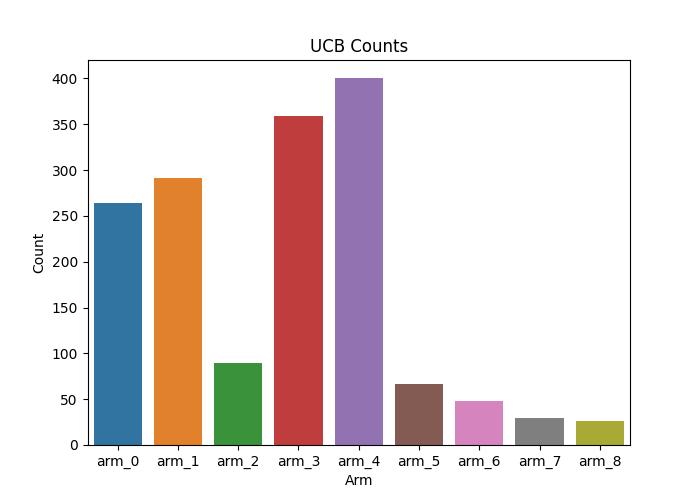

In [7]:
count_bar_plot_df = {"arm": [],
               "count": []}
for arm in arm_names:
    count_bar_plot_df["arm"].append(arm)
    count_bar_plot_df["count"].append(q_vals_df[f"{arm}_count"].values[-1])
# print(bar_plot_df)
plt.figure(figsize=(7, 5))
plt.title("UCB Counts")
sns.barplot(x="arm", y="count", data=count_bar_plot_df)
plt.ylabel("Count")
plt.xlabel("Arm")

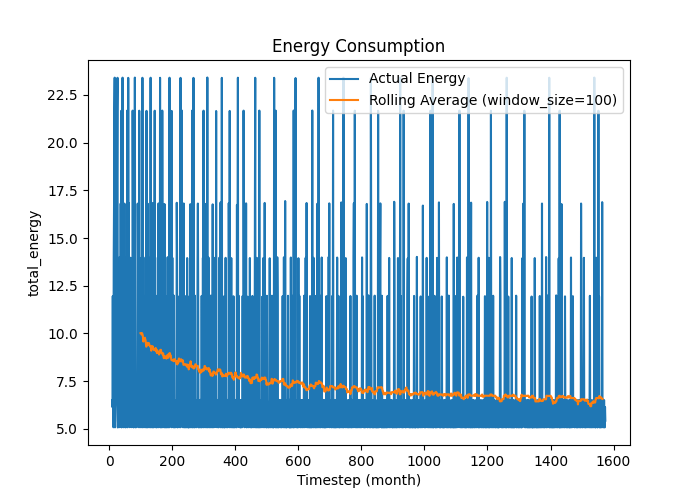

In [71]:

# running_average = q_vals_df["total_energy"].rolling(window=3).mean()
window_size = 100
alpha = 0.1
ema = q_vals_df["total_energy"].ewm(alpha=alpha, adjust=False).mean()
rolling_avg = q_vals_df["total_energy"].rolling(window=window_size).mean()

plt.figure(figsize=(7, 5))
plt.title("Energy Consumption")
sns.lineplot(x="timestep", y="total_energy", data=q_vals_df, label="Actual Energy")
plt.plot(rolling_avg, label=f"Rolling Average (window_size={window_size})")
# plt.plot(ema, label=f"EMA (alpha={alpha})")
plt.ylabel("total_energy")
plt.xlabel("Timestep (month)")
plt.legend()

## Multi Run Plots

In [4]:
root_dir = "../data/group_ucb_data/C_Runs"
runs = os.listdir(root_dir)
# exclusions = ["11", "14"]
# exclusions = ["34"]
exclusions = []
runs = list(set(runs) - set(exclusions))

run_dfs = {}
for run in runs:
    path = os.path.join(root_dir, run, "ucb_log_data.csv")
    run_dfs[run] = pd.read_csv(path)


In [5]:
start_timestep = 9  # Skip first len(arms)-1 (0-indexed) steps as they are pure exploration steps
end_timestep = 500 + start_timestep
mu = []
sigma = []
for i in range(start_timestep, end_timestep):
    energy_consumptions = []
    for run in run_dfs:
        # print(run)
        df = run_dfs[run]
        try:
            energy = df.loc[i, ["total_energy"]].values[0] / 4000000
        except:
            print(run)
        energy_consumptions.append(energy)
    mu.append(np.mean(energy_consumptions))
    sigma.append(np.std(energy_consumptions))
mu = np.array(mu)
sigma = np.array(sigma)

In [8]:
import pickle
with open("./C_mu.pkl", "wb+") as f:
    pickle.dump(mu, f)
with open("./C_sigma.pkl", "wb+") as f:
    pickle.dump(sigma, f)

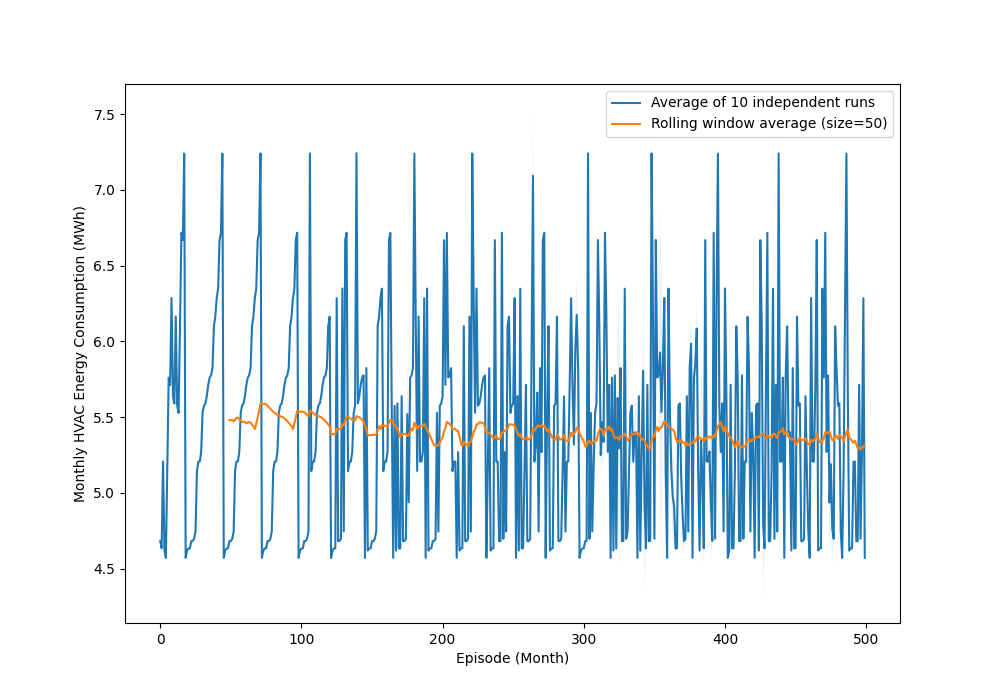

In [7]:
window_size = 50

plt.figure(figsize=(10, 7))
# plt.title(r"Building $B_{\text{Denver}}$")
plt.ylabel("Monthly HVAC Energy Consumption (MWh)")
plt.xlabel("Episode (Month)")
mu_temp = pd.Series(mu)
rolling_avg = mu_temp.rolling(window=window_size).mean()
plt.plot(list(range(len(mu))), mu, label="Average of 10 independent runs")
plt.fill_between(list(range(len(mu))), (mu-sigma), (mu+sigma), alpha=0.1)
plt.plot(list(range(len(mu))), rolling_avg, label="Rolling window average (size=50)")
plt.legend()

In [134]:
np.roll(mu, 10)

array([ 2.63275165, 13.38875479,  2.57882206, 20.70360416,  2.79552453,
        2.61808558,  2.74898832,  7.37139517,  2.57836449, 13.50813256,
        2.5751614 ,  2.61906789,  2.74954405,  2.79435352,  7.07923304,
        7.37134317, 13.38614812, 13.50954787, 20.70151471,  2.57880332,
        2.61828119,  2.74834252,  2.79509018,  7.0806913 ,  7.37073217,
        2.57909832,  2.61923199,  2.74981543,  2.79581463, 13.39027034,
       13.51007024,  7.08027402,  7.36747268,  2.57786163,  2.61889017,
        2.7505799 ,  2.79676375, 20.70583935,  2.57877515,  2.61857979,
        2.74980775,  7.07897289, 13.38846182,  2.79516731, 13.51479707,
        7.36911579,  2.58051825,  2.61914425,  2.74906446,  2.79715506,
        7.07704101,  7.37196159,  2.57928791,  2.62088775,  2.74791731,
        2.79601514, 13.38893989, 13.51089058, 20.7082559 ,  7.07706205,
        2.57984098,  2.62049947,  7.3684762 ,  2.74724989,  2.79297824,
        2.5792419 ,  2.6178461 ,  2.7483937 ,  2.79533885,  7.07